# Ch 2. Programming Probabilistically

In this chapter, we will cover the following topics:

- Probabilistic programming
- PyMC3 primer
- The coin-flipping problem revisited
- Summarizing the posterior
- The Gaussian and student's t models
- Comparing groups and the effect size
- Hierarchical models and shrinkage

In [32]:
import numpy as np
import pandas as pd
from scipy import stats
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

## Probabilistic programming

> Bayesian statistics is conceptually very simple; we have the knows and the unknowns; we use Bayes' theorem to condition the latter on the former. If we are lucky, this process will reduce the uncertainty about the unknowns. Generally, we refer to the knowns as data and treat it like a constant, and the unknowns as parameters and treat them as probability distributions.

## PyMC3 primer

- a library for probabilistic programming
- uses NumPy and Theano
    - Theano is a deep learning algorithm that supplies the automatic differentiation required for sampling by PyMC3
    - Theano also compiles the code to C for faster execution
- Theano is no longer developed, but the PyMC devs are currently maintaining it
    - the next version of PyMC will use a different backend

### Flipping coins the PyMC3 way

- make synthetic coin flipping data, but we know the real $\theta$ value

In [4]:
np.random.seed(123)
trials = 4
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data

array([1, 0, 0, 0])

### Model specification

- need to specify the likelihood function and prior probability distribution
    - likelihood: binomial distribution with $n=1$ and $p=\theta$
    - prior: beta distribution with $\alpha=1$ and $\beta=1$
        - this beta distribution is equivalent to a uniform distirbution from $[0,1]$

$$
\theta \sim \text{Beta}(\alpha, \beta) \\
y \sim \text{Bern}(p=\theta)
$$

- this model using PyMC3:

In [6]:
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1.0, beta=1.0)
    y = pm.Bernoulli('y', p=θ, observed=data)
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.


### Pushing the inference button

- the last line of the model specification above is "pressing the inference button"
    - asks for 1,000 samples from the posterior distribution

## Summarizing the posterior

- use `plot_trace()` to see the distribution of sampled values for $\theta$ and the MCMC chains

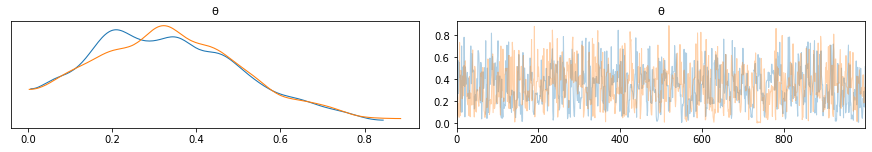

In [23]:
az_trace = az.from_pymc3(trace=trace, model=our_first_model)
p = az.plot_trace(az_trace)

- use `summary()` to get a Pandas data frame describing the posterior

In [24]:
az.summary(az_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.336,0.177,0.027,0.663,0.006,0.004,806.0,806.0,744.0,800.0,1.0


- use `plot_posterior()` to visualize the posterior distribution of $\theta$

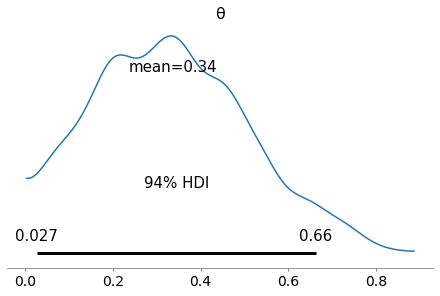

In [26]:
p = az.plot_posterior(az_trace)

### Posterior-based descisions

- sometimes need to go further than just descirbing the posterior and actually make a decision

#### ROPE

- **Region Of Practical Equivalence**: a region of the posteior distibution that would be effectively equivalent to a specific value
    - example: a fair coin has $\theta=0.5$ then the ROPE could be $[0.45, 0.55]$

> A ROPE is an arbitrary interval we choose based on background knowledge. Any value inside this interval is assumed to be of practical equivalence.

- comapre the ROPE against the **Highest-Posterior Density (HPD)**
- 3 possible scenarios:
    - the ROPE and HPD do not overalp: the coin is not fair
    - the ROPE contains the entire HPD: the coin is fair
    - the ROPE partially overlaps the HPD: the coin may be fair or unfair
- can include a range for the ROPE in `plot_posterior()`

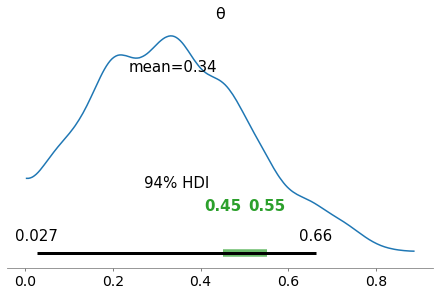

In [27]:
p = az.plot_posterior(az_trace, rope = [0.45, 0.55])

- can also compare the posterior against a reference value
    - example: 0.5 for a fair coin

array([<AxesSubplot:title={'center':'θ'}>], dtype=object)

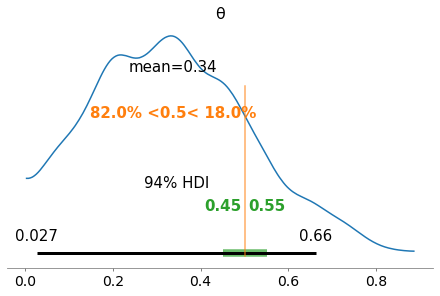

In [28]:
az.plot_posterior(az_trace, rope = [0.45, 0.55], ref_val = 0.5)

#### Loss functions

- loss functoin is a mathematical formalization of a cost/benefit trade-off
    - indicate how different the true and estimated values of a prameter are
- common loss functions:
    - *quadratic*: $(\theta - \hat{\theta})^2$
    - *absolute*: $| \theta - \hat{\theta} |$
    - *0-1*: $I(\theta \neq \hat{\theta})$
- since we don't know the true parameter value, instead try to find the value of $\hat{\theta}$ that minimizes the **expected loss function**
    - expected loss function is the loss function averages over the entire posterior distribution
- example below shows the absolute loss `lossf_a` and quadratic loss `lossf_b`

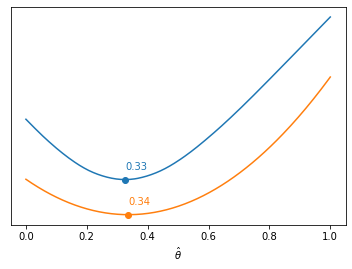

In [33]:
grid = np.linspace(0, 1, 200)
theta_pos = trace['θ']
lossf_a = [np.mean(abs(i - theta_pos)) for i in grid]
lossf_b = [np.mean((i - theta_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), 
                 color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat{\theta}$')

## Gaussians all the way down

